In this notebook I will be creating a classifier for the data set comprising of GEANT based simulations of electron-proton inelastic scattering measured by a particle detector system. The full data set can be found here https://www.kaggle.com/naharrison/particle-identification-from-detector-responses 


In [1]:
#Upload the packages we will be using
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import the data and set it to our data frame
df = pd.read_csv('pid-5M.csv')

Now we are going to explore the data a little bit to get a better feel for it.

In [3]:
df.head()

,id,p,theta,beta,nphe,ein,eout
0,211,0.780041,1.081480,0.989962,0,0.000000,0.000000
1,211,0.260929,0.778892,0.902450,0,0.000000,0.000000
2,2212,0.773022,0.185953,0.642428,4,0.101900,0.000000
3,211,0.476997,0.445561,0.951471,0,0.000000,0.000000
4,2212,2.123290,0.337332,0.908652,0,0.034379,0.049256


From the above we can see that our target ID is numerical which we will be mapping to a more readable form in a bit. We can also see that their are several zero values in the columns 'nphe', 'ein', and 'eout'. 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 7 columns):
id       int64
p        float64
theta    float64
beta     float64
nphe     int64
ein      float64
eout     float64
dtypes: float64(5), int64(2)
memory usage: 267.0 MB


In [5]:
df.describe()

,id,p,theta,beta,nphe,ein,eout
count,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06
mean,9.941839e+02,1.230053e+00,4.889321e-01,8.995796e-01,3.575243e+00,5.635883e-02,7.033195e-02
std,9.724034e+02,7.414895e-01,2.942161e-01,1.132321e-01,1.779236e+01,7.882675e-02,1.020604e-01
min,-1.100000e+01,2.101170e-01,9.222140e-02,5.500010e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.110000e+02,6.657510e-01,2.817420e-01,8.378760e-01,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.110000e+02,1.066150e+00,4.048670e-01,9.461940e-01,0.000000e+00,3.442440e-02,4.417490e-02
75%,2.212000e+03,1.649650e+00,6.117800e-01,9.855910e-01,0.000000e+00,6.834520e-02,9.365990e-02
max,2.212000e+03,5.286950e+00,2.219270e+00,1.499590e+00,3.490000e+02,8.993820e-01,1.097410e+00


In [6]:
null_tot = df.isnull().sum().sort_values(ascending=False)
percent_null = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
null_data = pd.concat([null_tot, percent_null], axis=1, keys=['Total', 'Percent'])
null_data


,Total,Percent
eout,0,0.0
ein,0,0.0
nphe,0,0.0
beta,0,0.0
theta,0,0.0
p,0,0.0
id,0,0.0


Luckily this data set is quite complete as there are no missing points.

In [7]:
#Simple percentage of the values in the dataframe that are zero
(df[df == 0].count()/df.count())*100

id        0.00000
p         0.00000
theta     0.00000
beta      0.00000
nphe     93.51718
ein      34.80742
eout     43.78022
dtype: float64

Unfortunately it seems that a very large percentage of 'nphe', 'ein', and 'eout' is zero and it will make this incredibly difficult to use.

In [8]:
(df['id'].value_counts()/df['id'].count())*100

 211     56.13666
 2212    38.91698
 321      4.64942
-11       0.29694
Name: id, dtype: float64

In addition to this a very small portion of the data set is the detection of a kaon and even less so a positron. Let's see if the non-zero values for our 'nphe', 'ein', and 'eout' columns can be used as a useful marker for our less present targets

In [9]:
df[df['nphe'] != 0]['id'].value_counts()/df[df['nphe'] != 0]['id'].count()*100

 211     74.562305
 2212    21.056269
 321      2.459115
-11       1.922312
Name: id, dtype: float64

In [10]:
df[df['ein'] != 0]['id'].value_counts()/df[df['ein'] != 0]['id'].count()*100

 2212    51.330903
 211     42.897152
 321      5.570358
-11       0.201587
Name: id, dtype: float64

In [11]:
df[df['eout'] != 0]['id'].value_counts()/df[df['eout'] != 0]['id'].count()*100

 2212    48.867142
 211     44.455777
 321      6.542395
-11       0.134686
Name: id, dtype: float64

Unfortunately although there is some variation in the respresentation it still stays relatively the same.

This is a fairly large data set and we will not be needing to work with all of the data points to get a clear model. So let's reduce this set to a more managable size and remove the variables that cannot be used.

In [12]:
#although it appears that the dataframe is not in any set order, we will shuffle it just to be sure
df_reduced = df.sample(frac=0.01).reset_index(drop=True)

In [13]:
df_reduced.drop(['nphe','ein', 'eout'], axis = 1, inplace = True)

In [14]:
df_reduced.head()

,id,p,theta,beta
0,211,0.989548,0.326810,0.993625
1,2212,0.892653,0.319936,0.689508
2,211,0.295109,0.532925,0.911725
3,211,0.277409,0.258574,0.886388
4,211,0.464179,0.936714,0.973289


In [15]:
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
id       50000 non-null int64
p        50000 non-null float64
theta    50000 non-null float64
beta     50000 non-null float64
dtypes: float64(3), int64(1)
memory usage: 1.5 MB


Now let's do a simple bit of mapping so that our 'id' column is a bit more interpritable

In [16]:
df_reduced['target'] = df_reduced['id'].map({211:'pion', -11:'positron', 321:'kaon', 2212:'proton'})
df_reduced.drop('id', axis = 1, inplace = True)
df_reduced.head()

,p,theta,beta,target
0,0.989548,0.326810,0.993625,pion
1,0.892653,0.319936,0.689508,proton
2,0.295109,0.532925,0.911725,pion
3,0.277409,0.258574,0.886388,pion
4,0.464179,0.936714,0.973289,pion


Now let's explore out data a bit with a pairplot to see if their is any visibile clustering

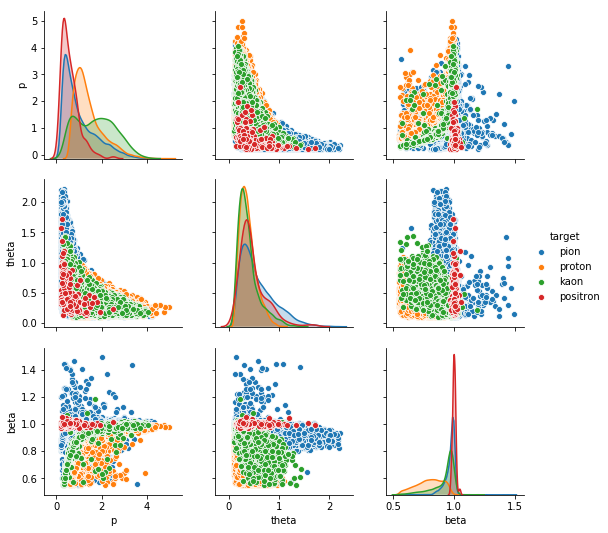

In [17]:
sns.pairplot(df_reduced,hue = 'target')

There does seem to be a fair bit of clustering which is good. Now let's check the distribution of our predictors.

In [18]:
from scipy.stats import norm
from scipy import stats

Skewness: 0.959189
Kurtosis: 0.539925


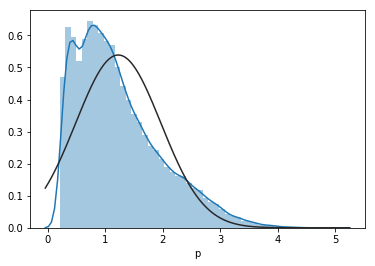

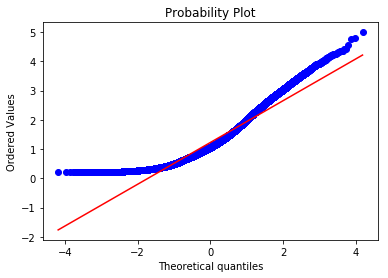

In [19]:
sns.distplot(df_reduced['p'], fit = norm);
print("Skewness: %f" % df_reduced['p'].skew())
print("Kurtosis: %f" % df_reduced['p'].kurt())
fig = plt.figure()
res = stats.probplot(df_reduced['p'], plot=plt)

Skewness: 1.523076
Kurtosis: 2.647358


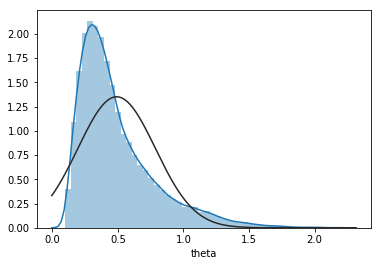

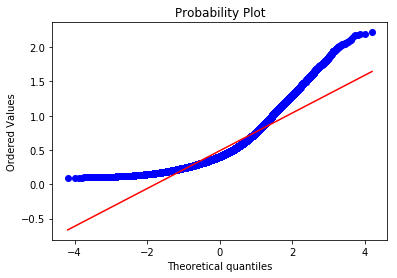

In [20]:
sns.distplot(df_reduced['theta'], fit= norm);
print("Skewness: %f" % df_reduced['theta'].skew())
print("Kurtosis: %f" % df_reduced['theta'].kurt())
fig = plt.figure()
res = stats.probplot(df_reduced['theta'], plot=plt)

Skewness: -1.113172
Kurtosis: 0.519149


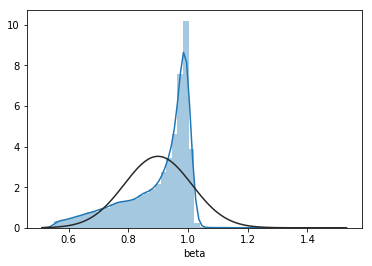

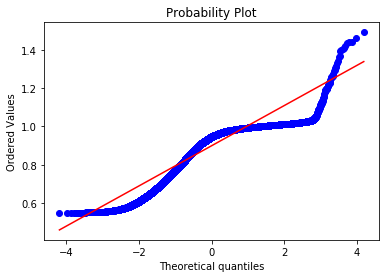

In [21]:
sns.distplot(df_reduced['beta'], fit = norm);
print("Skewness: %f" % df_reduced['beta'].skew())
print("Kurtosis: %f" % df_reduced['beta'].kurt())
fig = plt.figure()
res = stats.probplot(df_reduced['beta'], plot=plt)

We will be trying out best to get these values as close to a normal distribution as possible and for this we will be using the boxcox method. Note that boxcox returns a tuple when its variables are not set so these variables are simply set to y to unpack the tuple.

Skewness: -0.029813
Kurtosis: -0.674619


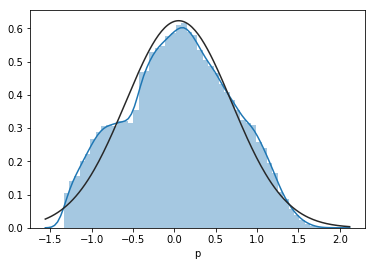

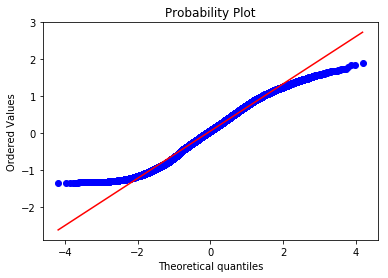

In [22]:
#df_reduced['p'] = np.log(df_reduced['p'])
df_reduced['p'], y = stats.boxcox(df_reduced['p'])
sns.distplot(df_reduced['p'], fit = norm);
print("Skewness: %f" % df_reduced['p'].skew())
print("Kurtosis: %f" % df_reduced['p'].kurt())
fig = plt.figure()
res = stats.probplot(df_reduced['p'], plot=plt)

Skewness: 0.009915
Kurtosis: -0.435521


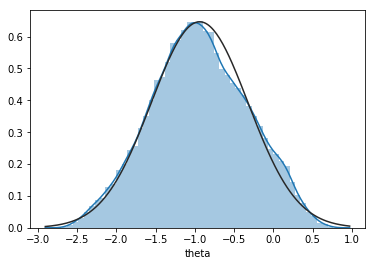

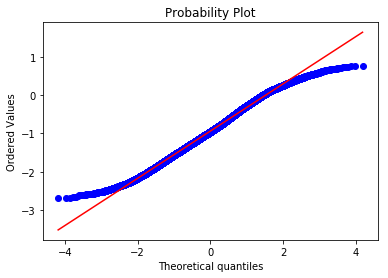

In [23]:
#df_reduced['theta'] = np.log(df_reduced['theta'])
df_reduced['theta'], y = stats.boxcox(df_reduced['theta'])
sns.distplot(df_reduced['theta'], fit = norm);
print("Skewness: %f" % df_reduced['theta'].skew())
print("Kurtosis: %f" % df_reduced['theta'].kurt())
fig = plt.figure()
res = stats.probplot(df_reduced['theta'], plot=plt)

Skewness: 0.144365
Kurtosis: 7.032378


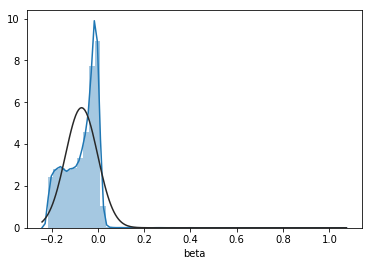

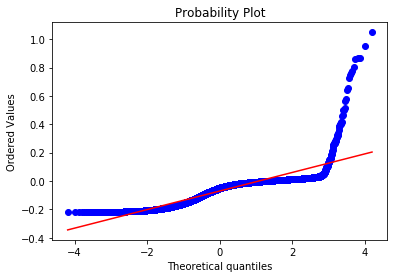

In [24]:
df_reduced['beta'], y = stats.boxcox(df_reduced['beta'])
sns.distplot(df_reduced['beta'], fit = norm);
print("Skewness: %f" % df_reduced['beta'].skew())
print("Kurtosis: %f" % df_reduced['beta'].kurt())
fig = plt.figure()
res = stats.probplot(df_reduced['beta'], plot=plt)

A fairly decent improvement on the first 2 but we will be forced to press on. Lets import our libraries for splitting out data and we will start off with a simple RandomForestClassifier

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [26]:
X = df_reduced.drop('target', axis = 1)
y = df_reduced['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [27]:
randfor = RandomForestClassifier(n_estimators=30)

In [29]:
randfor.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [30]:
predictions = randfor.predict(X_test)

Our model is trained and our predictions have been made, let's see how we did.

In [31]:
from sklearn.metrics import confusion_matrix, classification_report

In [33]:
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

        kaon       0.76      0.69      0.72       692
        pion       0.97      0.98      0.97      8385
    positron       0.80      0.36      0.50        44
      proton       0.98      0.99      0.99      5879

   micro avg       0.97      0.97      0.97     15000
   macro avg       0.88      0.75      0.80     15000
weighted avg       0.97      0.97      0.97     15000

[[ 476  186    0   30]
 [ 116 8187    4   78]
 [   0   28   16    0]
 [  34   25    0 5820]]


As far as predicting protons and pions are concerned that's fairly good for a first try. However the data set just does not have enough cases for positrons and kaon's. Let's try another method, being K nearest neighbours and let's hope the clustering we saw in our analysis pays off.

In [44]:
#import the libraries
from sklearn.neighbors import KNeighborsClassifier

In [49]:
#running a simple loop to determine our K
for n in range (1,10):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    predictions = knn.predict(X_test)
    print(knn.score(X_test, y_test))

0.9465333333333333
0.9400666666666667
0.9536
0.9504
0.9522666666666667
0.9515333333333333
0.9498666666666666
0.9494666666666667
0.9486666666666667


In [51]:
#Run our with our determined K and see more in detail metrics
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

        kaon       0.66      0.53      0.59       692
        pion       0.96      0.97      0.96      8385
    positron       0.55      0.14      0.22        44
      proton       0.98      0.98      0.98      5879

   micro avg       0.95      0.95      0.95     15000
   macro avg       0.78      0.66      0.69     15000
weighted avg       0.95      0.95      0.95     15000

[[ 367  284    0   41]
 [ 139 8150    5   91]
 [   0   38    6    0]
 [  50   48    0 5781]]


Well that is unfortunate. There is still one more method I would like to try that being a Support Vector Machine.

In [52]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [72]:
svc = SVC()
svc.fit(X_train, y_train)
predictions = svc.predict(X_test)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

        kaon       0.89      0.25      0.39       692
        pion       0.94      0.99      0.96      8385
    positron       0.00      0.00      0.00        44
      proton       0.98      0.99      0.98      5879

   micro avg       0.95      0.95      0.95     15000
   macro avg       0.70      0.56      0.58     15000
weighted avg       0.95      0.95      0.94     15000

[[ 173  469    0   50]
 [  20 8272    0   93]
 [   0   44    0    0]
 [   2   42    0 5835]]


As with KNN this method is not much better. I had tried playing around with the individual class weights but to not much avail.

Future Work:
Since the data set is so large a potential solution to the bias of the data set towards protons and pions would be to intentionally create a data set with each of the targets equally represented. I do not know how this would effect the results or how it would effect future predictions but it's something to look into.